In [1]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

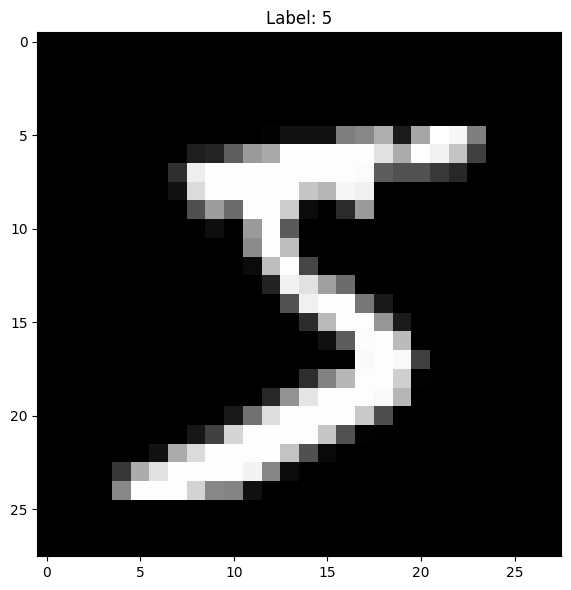

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np

# Create images/classification directory
IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Save figure utility
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# Display an example digit
plt.figure(figsize=(6, 6))
plt.imshow(X[0].reshape(28, 28), cmap="gray")
plt.title(f"Label: {y[0]}")
save_fig("mnist_digit_example")
plt.show()


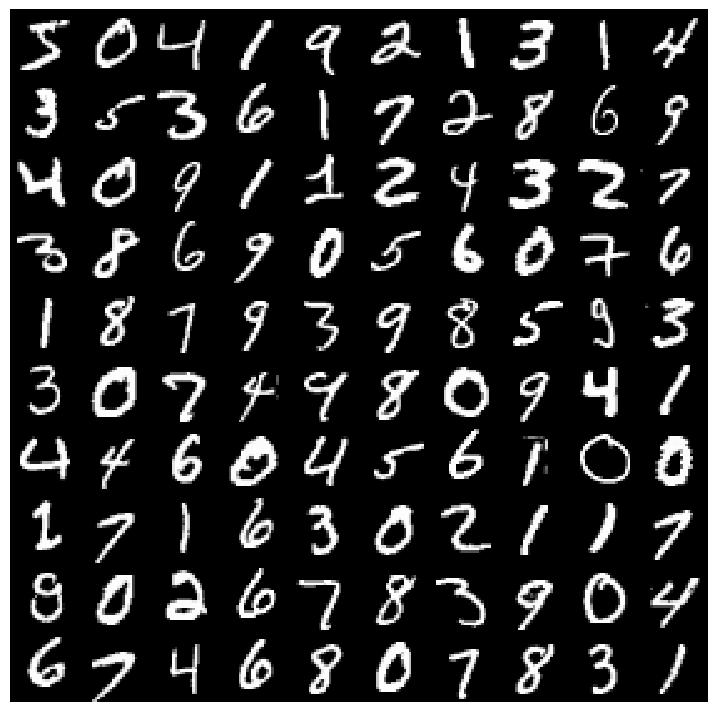

In [6]:
# Define the plot_digit function
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training Binary Classifier

In [8]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [16]:
from sklearn.linear_model import SGDClassifier

# Check that both classes are present
unique_classes = np.unique(y_train_5)
print("Unique classes in y_train_5:", unique_classes)

sgd_clf = SGDClassifier(random_state=42)
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Unique classes in y_train_5: [False]


In [18]:
some_digit = X_train[0]
sgd_clf.fit(X_train, y_train_5)  # Fit the model before prediction
sgd_clf.predict([some_digit])

array([ True])

Performance Measure

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [21]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [22]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Confusion Matrix

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # Precision: Proportion of positive identifications that were actually correct
recall_score(y_train_5, y_train_pred)  # Recall: Proportion of actual positives that were identified correctly

# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [26]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

np.float64(0.6511713705958311)

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [28]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

np.float64(0.7325171197343847)

Precission Recall

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [31]:
y_some_digit_pred

array([ True])

In [32]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

array([ True])

In [33]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

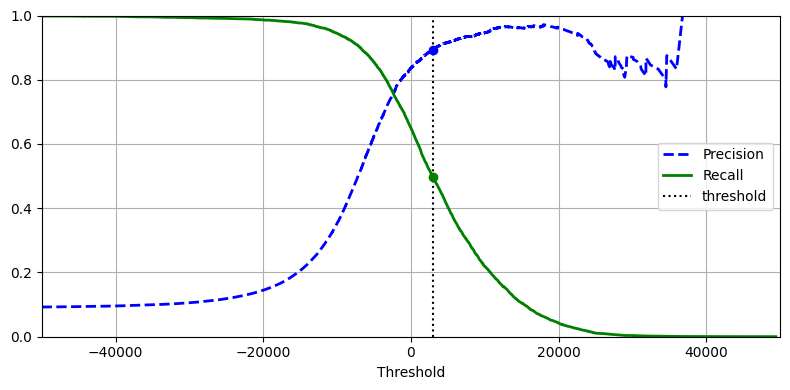

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

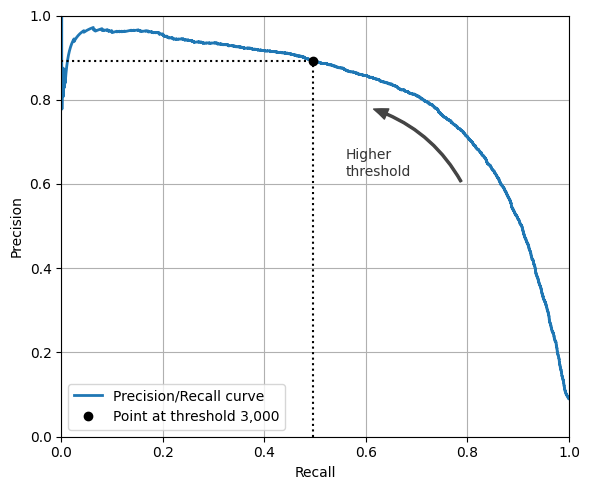

In [36]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [37]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [38]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

ROC Curve

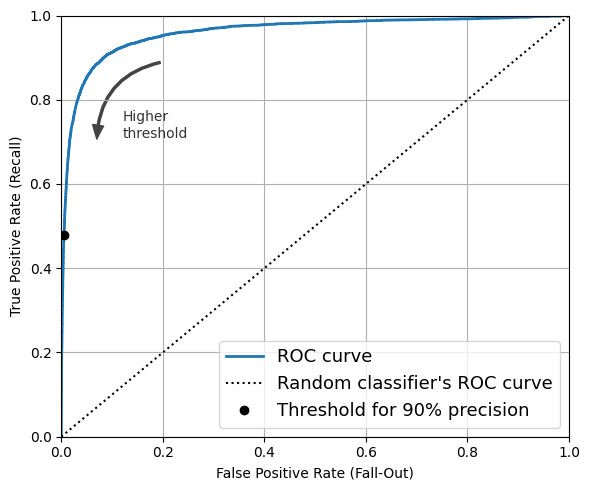

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [43]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

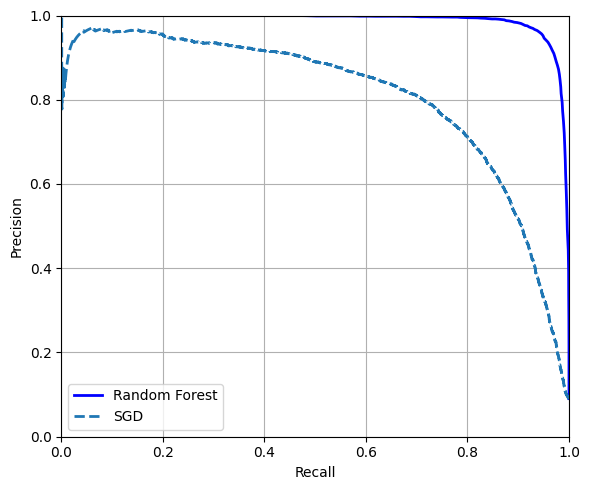

In [44]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [45]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [47]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [48]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

Multiclass Classification
SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [49]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [50]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [52]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [53]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [54]:
svm_clf.classes_[class_id]

np.uint8(5)

In [55]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [56]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
len(ovr_clf.estimators_)

10

In [58]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [59]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Error Analysis

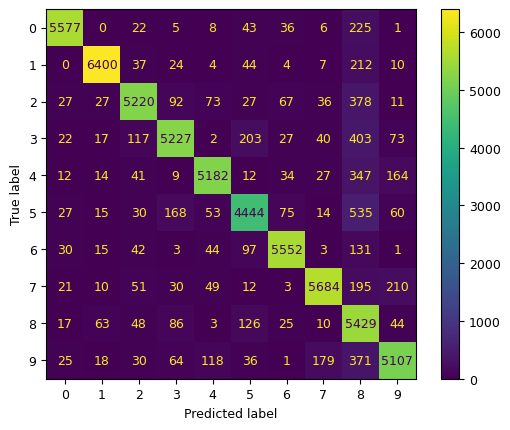

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

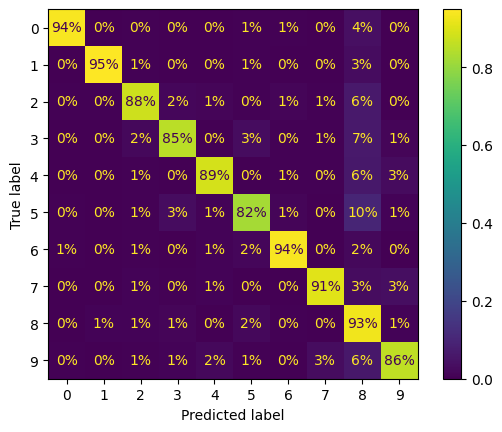

In [63]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

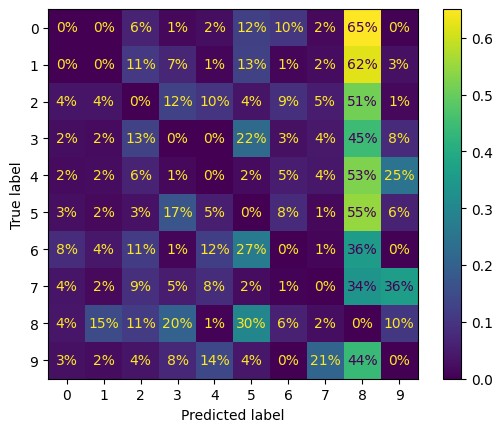

In [64]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,sample_weight=sample_weight,normalize="true", values_format=".0%")
plt.show()

Multilabel Classification

In [66]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [67]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [69]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [70]:
chain_clf.predict([some_digit])

array([[0., 1.]])

In [71]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

MultiOutput Classification

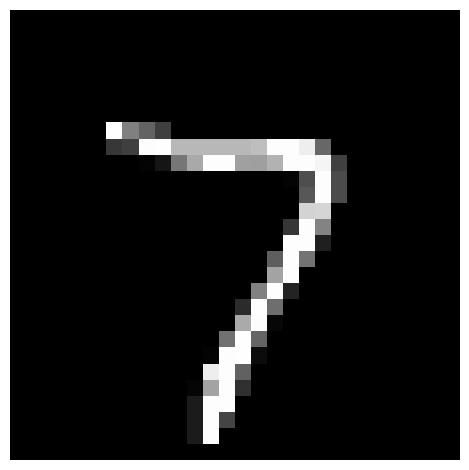

In [72]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  
plt.show()

EXERCISE QUESTION'S SOLUTION

Q1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
 on the test set. Hint: the KNeighborsClassifier works quite well for this task;
 you just need to find good hyperparameter values (try a grid search on the
 weights and n_neighbors hyperparameters).

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance']
}

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train[:6000], y_train[:6000])  # Use smaller subset to speed up

# Evaluate on test data
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
# Display best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.9s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.9s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   1.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.6s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.5s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.5s
[CV] END .....................n_neighbors=4, weights=uniform; total time=   1.1s
[CV] END .....................n_neighbors=4, weights=uniform; total time=   0.8s
[CV] END .....................n_neighbors=4, weights=uniform; total time=   1.0s
[CV] END ....................n_neighbors=4, weights=distance; total time=   0.5s
[CV] END ....................n_neighbors=4, weights=distance; total time=   0.7s
[CV] END ....................n_neighbors=4, weigh

 Q2. Write a function that can shift an MNIST image in any direction (left, right, up,
 or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set.
 You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

Shift Function

In [75]:
def shift_image(image, direction):
    image = image.reshape(28, 28)
    if direction == "left":
        shifted = np.roll(image, -1, axis=1)
        shifted[:, -1] = 0
    elif direction == "right":
        shifted = np.roll(image, 1, axis=1)
        shifted[:, 0] = 0
    elif direction == "up":
        shifted = np.roll(image, -1, axis=0)
        shifted[-1, :] = 0
    elif direction == "down":
        shifted = np.roll(image, 1, axis=0)
        shifted[0, :] = 0
    return shifted.reshape(784)


Data Augmentation

In [76]:
X_augmented = []
y_augmented = []

for img, label in zip(X_train[:5000], y_train[:5000]):
    for direction in ["left", "right", "up", "down"]:
        X_augmented.append(shift_image(img, direction))
        y_augmented.append(label)

X_train_aug = np.concatenate([X_train[:5000], X_augmented])
y_train_aug = np.concatenate([y_train[:5000], y_augmented])


 Q3. Tackle the Titanic dataset. A great place to start is on Kaggle.

In [78]:
import zipfile
import os

zip_path = "Titanic_DataSet.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("extracted")

os.listdir("extracted")


['Titanic-Dataset.csv']

In [79]:
import pandas as pd

df = pd.read_csv("extracted/Titanic-Dataset.csv")
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [80]:
# Check data types and non-null counts
df.info()

# Check basic statistics for numerical columns
df.describe()

# Check categorical columns
df.select_dtypes(include=['object']).nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [81]:
# Count missing values in each column
df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [82]:
# Fill missing 'Age' values with the median age
df['Age'].fillna(df['Age'].median(), inplace=True)

# Drop 'Cabin' column due to many missing values
df.drop('Cabin', axis=1, inplace=True)

# Fill missing 'Embarked' values with the mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


C:\Users\FALCON JNB\AppData\Local\Temp\ipykernel_2976\3866236775.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\FALCON JNB\AppData\Local\Temp\ipykernel_2976\3866236775.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [83]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)


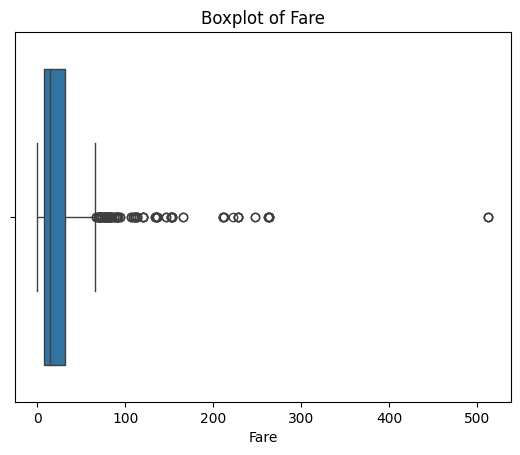

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for 'Fare'
sns.boxplot(x=df['Fare'])
plt.title('Boxplot of Fare')
plt.show()


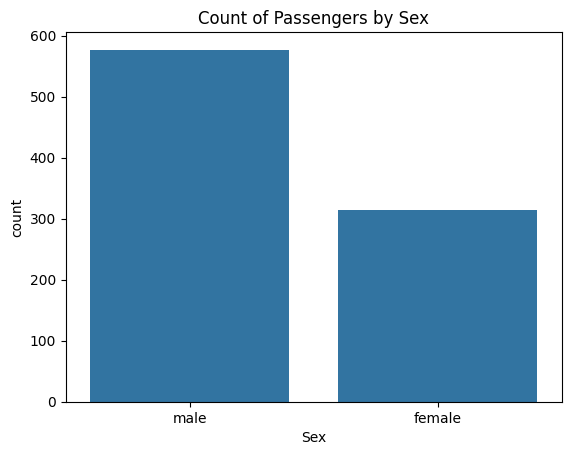

In [85]:
# Bar chart for 'Sex'
sns.countplot(x='Sex', data=df)
plt.title('Count of Passengers by Sex')
plt.show()


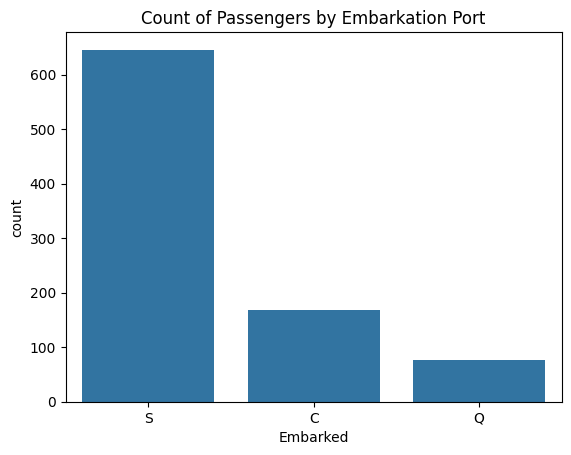

In [86]:
# Bar chart for 'Embarked'
sns.countplot(x='Embarked', data=df)
plt.title('Count of Passengers by Embarkation Port')
plt.show()


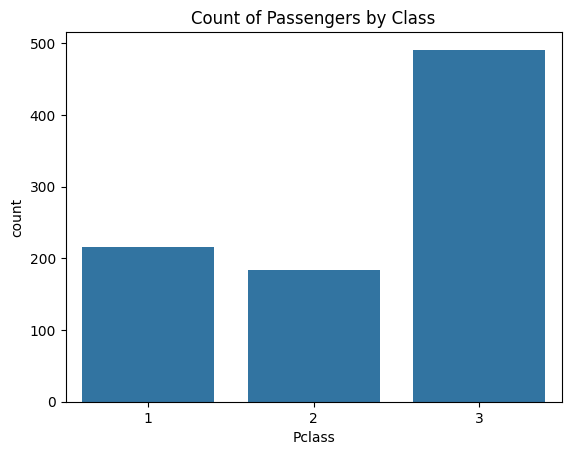

In [87]:
# Bar chart for 'Pclass'
sns.countplot(x='Pclass', data=df)
plt.title('Count of Passengers by Class')
plt.show()

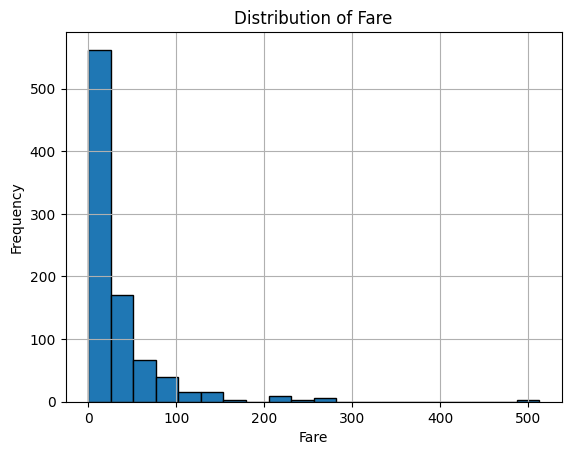

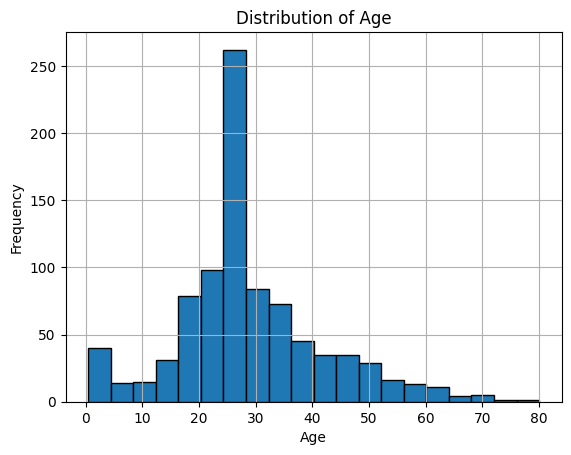

In [88]:
# Histogram for 'Fare'
df['Fare'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

# Histogram for 'Age'
df['Age'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


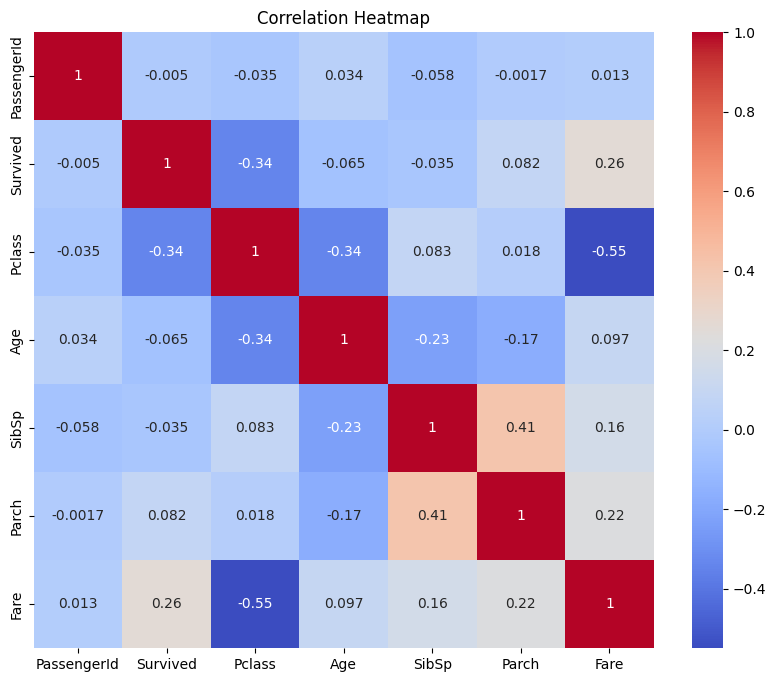

In [90]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Q4. Build a spam classifier (a more challenging exercise):
 • Download examples of spam and ham from Apache SpamAssassin’s public
 datasets.
 • Unzip the datasets and familiarize yourself with the data format.
 • Split the datasets into a training set and a test set.
 • Write a data preparation pipeline to convert each email into a feature vector.
 Your preparation pipeline should transform an email into a (sparse) vector
 indicating the presence or absence of each possible word. For example, if all
 emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
 “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
 (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
 present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
 each word.
 • You may want to add hyperparameters to your preparation pipeline to control
 whether or not to strip off email headers, convert each email to lowercase,
 remove punctuation, replace all URLs with “URL,” replace all numbers with
 “NUMBER,” or even perform stemming (i.e., trim off word endings; there are
 Python libraries available to do this).
 • Then try out several classifiers and see if you can build a great spam classifier,
 with both high recall and high precision

In [91]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [93]:
import urllib.request

ham_dir, spam_dir = fetch_spam_data()

C:\Users\FALCON JNB\AppData\Local\Temp\ipykernel_2976\1017635056.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_bz2_file.extractall(path=spam_path)


In [94]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [95]:
len(ham_filenames)

2500

In [96]:
len(spam_filenames)

500

In [97]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [98]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

In [99]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [100]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [101]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [102]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [103]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [104]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [105]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [106]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [107]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [108]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\FALCON JNB\AppData\Local\Temp\ipykernel_2976\3203418293.py:6: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)


In [109]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [110]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [111]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [112]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [116]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [117]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# if running this notebook on Colab or Kaggle, we just pip install urlextract
if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

In [119]:
import urlextract # may require an Internet connection to download root domain

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [120]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [121]:
# Example usage of the EmailToWordCounterTransformer
from sklearn.pipeline import Pipeline   

X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [122]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [123]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20 stored elements and shape (3, 11)>

In [124]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

In [125]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [126]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

np.float64(0.985)

In [128]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 95.88%
Recall: 97.89%
